In [228]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [2]:
all_files = glob.glob("../roll_data/*-steal_attempt.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [12]
# seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

102747

In [3]:
# df.loc[df["batter_name"].isna(),"batter_name"]

In [4]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["batter_name"]].isna().any():
        # row["batter_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.35
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul, attrs

def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul


In [5]:
# pd.set_option("display.max_rows", 60)  # default 60
# df.loc[25077]

In [6]:
# df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [26]:
# df["baserunner_n"] = [int(np.floor(len(x) / 40)) for x in df.loc[:, "baserunner_count"]]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

df["incon_center"] = df["ballpark_inconvenience"] - 0.5
df["elong_center"] = df["ballpark_elongation"] - 0.5

In [27]:
for attr in [
    # "batter_buoyancy",
    # "batter_divinity",
    # "batter_martyrdom",
    # "batter_moxie",
    # "batter_musclitude",
    # "batter_thwackability",
    # "batter_coldness",
    # "batter_overpowerment",
    # "batter_ruthlessness",
    # "batter_shakespearianism",
    # "batter_suppression",
    # "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    # "batter_anticapitalism",
    # "batter_chasiness",
    # "batter_omniscience",
    # "batter_tenaciousness",
    # "batter_watchfulness",
    # "batter_pressurization",
    # "batter_cinnamon",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr] * (1 + 0.2 * x["batter_vibes"]),
                                  axis=1)
for attr in [
    # "batter_patheticism",
    # "batter_tragicness",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] / x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr] * (1 + 0.2 * x["batter_vibes"]),
                                  axis=1)
    # df[attr + "_mul_vibe"] = df[attr] * df["batter_mul"] * (1 + 0.2 * df["batter_vibes"])

In [28]:
df = df.copy()
for attr in [
    # "pitcher_buoyancy",
    # "pitcher_divinity",
    # "pitcher_martyrdom",
    # "pitcher_moxie",
    # "pitcher_musclitude",
    # "pitcher_patheticism",
    # "pitcher_thwackability",
    # "pitcher_tragicness",
    # "pitcher_ruthlessness",
    # "pitcher_overpowerment",
    # "pitcher_unthwackability",
    # "pitcher_shakespearianism",
    # "pitcher_suppression",
    # "pitcher_coldness",
    # "pitcher_base_thirst",
    # "pitcher_continuation",
    # "pitcher_ground_friction",
    # "pitcher_indulgence",
    # "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    # "pitcher_pressurization",
    # "pitcher_cinnamon",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [29]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])

df = df.copy()

In [30]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealAttempt0    51496
StealAttempt1    26262
StealAttempt2    24989
dtype: int64

In [1304]:
dfc = df[df["event_type"] == "StealAttempt0"].copy()
for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE",
                    "GROWTH", "SINKING_SHIP", "TRAVELING", "ON_FIRE", "CHUNKY", "SMOOTH"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc["laser_thirst"] = dfc["batter_laserlikeness_mul_vibe"] * dfc["batter_base_thirst_mul_vibe"]
# dfc["laser_thirst"] = dfc["batter_laserlikeness_mul_vibe"] * dfc["batter_base_thirst"]
# dfc["laser_thirst"] = dfc["batter_laserlikeness"] * dfc["batter_base_thirst"]


dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1) & (dfc["fielder_mul"] == 1)].copy()

# dfc = dfc[dfc["stadium_id"].isna()].copy()

dfc = dfc[dfc["roll"] > 0.001].copy()

# dfc["roll_log"] = np.log(dfc["roll"])
# dfc["lt_log"] = np.log(dfc["laser_thirst"])
# dfc["laser_log"] = np.log(dfc["batter_laserlikeness"])

# dfc["thirst_log"] = np.log(dfc["batter_base_thirst"])

# dfc["watch"] = (
#     # 3 * dfc["pitcher_watchfulness_mul_vibe"]
#     # + 1 * dfc["fielder_watchfulness_mul_vibe"]
#     3 * dfc["pitcher_watchfulness"]
#     + 1 * dfc["fielder_watchfulness"]
# ) / 1
# dfc["watch_log"] = np.log(dfc["watch"])
# dfc["watch_pow"] = dfc["watch"]**1.5
# dfc["lt_pow"] = dfc["laser_thirst"]**1.5

# dfc = dfc[dfc["laser_thirst"] > 1e-3].copy()
len(dfc)
# dfc["laser_thirst"].min()
# dfc.groupby("ballpark_inconvenience").size()

36579

In [1361]:
# ### Iterating a fit...
# # fitting to laser_thirst and watch
# # [0.03823398]
# # (0.12963858063456313, 'laser_thirst')
# # (-0.08346479052027601, 'watch')
# dfc["combined"] = 0.12*dfc["laser_thirst"] - 0.02*dfc["watch"]
# # dfc["combined_log"] = np.log(dfc["combined"])
# # dfc = dfc[~dfc["combined_log"].isna()].copy()
# # fitting roll_log to combined_log gives me this:
# # [-1.20011315]
# # (0.41525631384982287, 'combined_log')
# # and it doesn't seem that great? idk...but...
# dfc["combined_pow"] = dfc["combined"]**0.4
# # fit is bad, it's definitely the wrong power.

# # fitting roll_log to laser_log and thirst_log gives me:
# # intercept: -2.467090405417344
# # (1.2288955585926205, 'laser_log')
# # (0.7401914421496469, 'thirst_log')
# # there's a definite dependence on watch that isn't in here yet, but...
# # what if i redefine laser_thirst...
# dfc["laser_thirst_2"] = (
#     dfc["batter_laserlikeness"]**1.5
#     * dfc["batter_base_thirst"]**1
#     * (1 + 0.2 * dfc["batter_vibes"])
# )

# dfc["laser_thirst_3"] = (
#     dfc["batter_laserlikeness"]**1.5
#     * dfc["batter_base_thirst"]**1.0
#     * (1 + 0.2 * dfc["batter_vibes"])**1.5
# )
# dfc["lt3_log"] = np.log(dfc["laser_thirst_3"])

# # lt_2 gives me a better fit...
# # intercept: 0.038309967864791565
# # (0.1315398571140168, 'laser_thirst_2')
# # (-0.021317857978842874, 'watch')
# # where watch is a 3:1 ratio of pitcher to fielder watchfulness
# # so if i add the watch factor to roll, and do another log...
# dfc["roll_adj"] = dfc["roll"] + 0.02 * dfc["watch"] - 0.05
# dfc["roll_adj_log"] = np.log(dfc["roll_adj"])
# dfc["vibe_log"] = np.log((1 + 0.2 * dfc["batter_vibes"]))

# dfc["combined"] = 0.12*dfc["laser_thirst_2"] - 0.02*dfc["watch"]

# # idea from astrid: (laser + thirst)**power
# dfc["l_plus_t"] = (dfc["batter_laserlikeness_mul_vibe"] + dfc["batter_base_thirst_mul_vibe"])
# dfc["l_plus_t_log"] = np.log(dfc["l_plus_t"])


# / dfc["batter_base_thirst"]

dfc["pwatch"] = dfc["pitcher_watchfulness"] #* (1 + 0.2*dfc["pitcher_vibes"])
dfc["fwatch"] = dfc["fielder_watchfulness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["watch"] = ((3*dfc["pwatch"] + dfc["fwatch"])/4)

# dfc["roll_mod"] = (dfc["roll"] - 0.05 + 0.08 * dfc["watch"])
dfc["roll_mod"] = (dfc["roll"] + 0.08 * dfc["watch"])

dfc["laser_vibe"] = dfc["batter_laserlikeness_mul_vibe"]
dfc["laser"] = dfc["batter_laserlikeness_mul_vibe"]
dfc["lasersq"] = dfc["batter_laserlikeness_mul_vibe"]**2
dfc["lasersq_thirst"] = dfc["lasersq"] * dfc["batter_base_thirst"]

dfc["laser_thirst"] = dfc["batter_laserlikeness_mul_vibe"] * dfc["batter_base_thirst"]
dfc["laser_thirstsq"] = dfc["batter_laserlikeness_mul_vibe"] * (dfc["batter_base_thirst"]**2)
dfc["thirstsq"] = dfc["batter_base_thirst"]**2
dfc["thirst"] = dfc["batter_base_thirst"]
dfc["thirstpow"] = dfc["batter_base_thirst"]**0.9


dfc["park_factors"] = dfc["incon_center"] + 2 * dfc["elong_center"]
# dfc["park_factors"] = dfc["ballpark_inconvenience"] + 2 * dfc["ballpark_elongation"]

# dfc["laser_thirst_term"] = dfc["thirst"] * (dfc["laser"]**1.7)
dfc["laser_thirst_term"] = dfc["thirst"] * (3 * dfc["laser"]**2 + dfc["laser"]) / 4

dfc["thirst_elong"] =  dfc["thirst"] * dfc["ballpark_elongation"]
dfc["thirst_incon"] =  dfc["thirst"] * dfc["ballpark_inconvenience"]
dfc["laser_elong"] =  dfc["laser"] * dfc["ballpark_elongation"]
dfc["laser_incon"] =  dfc["laser"] * dfc["ballpark_inconvenience"]

# dfc["roll_log"] = np.log(dfc["roll_mod"])
# dfc["laser_log"] = np.log(0.205 + dfc["laser"]* (1+0.2*dfc["runner_vibes"])) 

# alright yknow what? let's just pin the factors I know about and throw in a bunch of others

In [1370]:
X = dfc[
    [
        "passed",
        # "roll",
        "roll_mod",
        # "laser",
        "lasersq",
        # "laser_thirst",
        # "lasersq_thirst",
        "laser_thirst_term",
        # "laser_thirstsq",
        # "thirst",
        # "thirstsq",
        "thirstpow",
        # "laser_elong",
        # "laser_incon",
        # "watch",
        # "pwatch",
        # "fwatch",
        # "watch_log",
        # "watch_pow",
        "park_factors",
        # "incon_center",
        # "elong_center",
    ]
]
# X = X[X['roll'] < 0.85]
# X = X[~X["roll_adj_log"].isna()]
y = X["passed"]
y=y.astype('int')
X = X.drop("passed", axis=1)

# pin_intercept = 0.042838197858485604
pin_intercept = None
pins = [
    # (0.01, "lasersq"),
    # (0.022, "laser_thirst"),
    # (0.06, "lasersq_thirst"),
    # (0.002, "laser_vibe"),
    # (0.014, "batter_base_thirst"),
    # (-0.02, "fwatch"),
    # (-0.06, "pwatch"),
    # (0.016, "laser_thirstsq"),
    # best fit from s12, 3 outliers :pensibr:
    # pin_intercept = 0.04239774709752158
    # (0.0005427620213285244, 'laser_vibe'),
    # (0.013370223441778063, 'lasersq'),
    # (0.022007321275998727, 'laser_thirst'),
    # (0.05546898054971845, 'lasersq_thirst'),
    # (0.003113192914613909, 'laser_thirstsq'),
    # (0.013484975624230513, 'batter_base_thirst'),
    # (-0.06024968508394561, 'pwatch'),
    # (-0.019527679299242828, 'fwatch'),
    # s13:
    # (0.0012317407889457, 'laser_vibe'),
    # (0.008551044135922201, 'lasersq'),
    # (0.02716057861600519, 'laser_thirst'),
    # (0.07689393162898282, 'lasersq_thirst'),
    # (0, 'laser_thirstsq'),
    # (0.017020462307163243, 'batter_base_thirst'),
    # (-0.06, 'pwatch'),
    # (-0.02, 'fwatch'),
    # (-0.08, 'watch'),
    # (-0.032, "park_factors"),
    # (-0.08, "watch"),
    # (0.010828859499095043, "lasersq"),
    # (0.1, 'laser_thirst_term'),
    # (0.016, 'batter_base_thirst'),
    # (0., 'thirst'),
    # (0.03, 'laser_thirst'),
    # (0, 'laser_thirstsq'),
    # (0.01783258760395072, 'thirstpow')
]
for val, var in pins:
    X["roll_mod"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
# print(len(dfc[~dfc["passed"]]))
# print(len(dfc[dfc["passed"]]))
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

[[35033     4]
 [    4  1538]]
8 outliers
0.9997812952787118
intercept: 0.043019535064043206
(0.010851314764286355, 'lasersq')
(0.10062332590266602, 'laser_thirst_term')
(0.017224762013956525, 'thirstpow')
(-0.03200393961381777, 'park_factors')


Optimal number of features : 7
(ranking, name): (1, 'roll_mod')
(ranking, name): (1, 'lasersq')
(ranking, name): (1, 'laser_thirst')
(ranking, name): (1, 'lasersq_thirst')
(ranking, name): (1, 'laser_thirst_term')
(ranking, name): (1, 'thirst')
(ranking, name): (1, 'thirstsq')
(ranking, name): (2, 'park_factors')


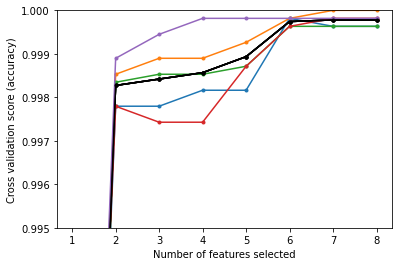

In [1173]:
sc = StandardScaler(with_mean=False)
X2 = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
# Create the RFE object and compute a cross-validated score.
svc = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-12)

# The "accuracy" scoring shows the proportion of correct classifications
nfolds = 5
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(nfolds),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X2, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
for n in range(nfolds):
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['split'+str(n)+'_test_score']) + min_features_to_select),
        rfecv.cv_results_['split'+str(n)+'_test_score'], '.-'
    )
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
        rfecv.cv_results_['mean_test_score'], 'k.-'
    )
# plt.show()
plt.ylim(0.995,1.0)
# plt.yscale("log")
# rfecv.cv_results_
for pair in zip(rfecv.ranking_, X.columns):
    print("(ranking, name):", pair)
# rfecv.support_

In [907]:
Xr = pd.DataFrame(rfecv.transform(X), columns=rfecv.get_feature_names_out())
Xr = X.copy()
# Xr = Xr.drop("laser", axis=1)
# Xr = Xr.drop("laser_thirstsq", axis=1)
Xr = Xr.drop("park_factors", axis=1)
# Xr = Xr.drop("omi_center", axis=1)

# pin_intercept = 0.0435
pin_intercept = None
pins = [
    # (-0.08, 'watch'),
    # (0, 'laser'),
    # (0.1, 'laser_thirst_term'),
    # (0.00, 'lasersq'),
    # (0.02, 'thirst'),
    # (0, 'laser_thirstsq'),
    # (-0.0012, 'thirstsq'),
]
for val, var in pins:
    Xr["roll_mod"] -= Xr[var] * val
    Xr = Xr.drop(var, axis=1)

Xr2 = pd.DataFrame(sc.fit_transform(Xr), columns=Xr.columns)
if pin_intercept is not None:
    Xr2.iloc[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(Xr2, y)
predictionsvm = trainedsvm.predict(Xr2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(Xr2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), Xr.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

[[25980    85]
 [  109  1044]]
194 outliers
0.9928723638768462
intercept: 0.04297453773521002
(0.12280744585727522, 'laser_thirst_term')


In [889]:
X = dfc[
    [
        "passed",
        "roll",
        "laser",
        "thirst",
        "watch",
    ]
]

y = X["passed"]
y=y.astype('int')
X = X.drop("passed", axis=1)

poly = PolynomialFeatures(3)

Xp = pd.DataFrame(poly.fit_transform(X.iloc[:,1:3]), columns=["roll", *poly.get_feature_names_out()[1:]])
print(X.iloc[0:5,:])
Xp["roll"] = np.array(X["roll"])

Xp["watch"] = np.array(X["watch"])
print(Xp.iloc[0:5,:])

           roll     laser    thirst     watch
19937  0.177926  1.293453  1.278638  0.448024
19949  0.934362  1.066666  0.995628  0.421149
19954  0.253606  1.066666  0.995628  0.448024
19960  0.982322  1.066666  0.995628  0.470129
19967  0.727885  0.265690  0.850054  0.618948
       roll     laser    thirst   laser^2  laser thirst  thirst^2   laser^3  \
0  0.177926  1.293453  1.278638  1.673020      1.653858  1.634915  2.163972   
1  0.934362  1.066666  0.995628  1.137777      1.062003  0.991276  1.213628   
2  0.253606  1.066666  0.995628  1.137777      1.062003  0.991276  1.213628   
3  0.982322  1.066666  0.995628  1.137777      1.062003  0.991276  1.213628   
4  0.727885  0.265690  0.850054  0.070591      0.225851  0.722592  0.018755   

   laser^2 thirst  laser thirst^2  thirst^3     watch  
0        2.139186        2.114685  2.090464  0.448024  
1        1.132803        1.057361  0.986942  0.421149  
2        1.132803        1.057361  0.986942  0.448024  
3        1.132803        

/Users/robbyblum/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimal number of features : 8
(ranking, name): (1, 'roll')
(ranking, name): (1, 'laser')
(ranking, name): (1, 'thirst')
(ranking, name): (1, 'laser^2')
(ranking, name): (1, 'laser thirst')
(ranking, name): (2, 'thirst^2')
(ranking, name): (1, 'laser^3')
(ranking, name): (1, 'laser^2 thirst')
(ranking, name): (4, 'laser thirst^2')
(ranking, name): (3, 'thirst^3')
(ranking, name): (1, 'watch')


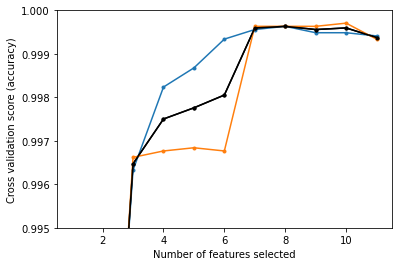

In [890]:
sc = StandardScaler(with_mean=False)
X2 = pd.DataFrame(sc.fit_transform(Xp), columns=Xp.columns)
# Create the RFE object and compute a cross-validated score.
svc = svm.LinearSVC(dual=False, max_iter=100000, C=1000000, tol=1e-12)

# The "accuracy" scoring shows the proportion of correct classifications
nfolds = 2
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(nfolds),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X2, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
for n in range(nfolds):
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['split'+str(n)+'_test_score']) + min_features_to_select),
        rfecv.cv_results_['split'+str(n)+'_test_score'], '.-'
    )
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
        rfecv.cv_results_['mean_test_score'], 'k.-'
    )
# plt.show()
plt.ylim(0.995,1.0)
# plt.yscale("log")
# rfecv.cv_results_
for pair in zip(rfecv.ranking_, Xp.columns):
    print("(ranking, name):", pair)
# rfecv.support_

In [635]:
dfc["term1"] = (dfc["laser"] - 1) * dfc["thirst"]**2
dfc["term2"] = (dfc["laser"] + 0.2)**2
dfc["term3"] = dfc["thirst"] * (dfc["laser"] + 0.2)**2

In [636]:
# Xr = pd.DataFrame(rfecv.transform(Xp), columns=rfecv.get_feature_names_out())
# Xp["term1"] = np.array(dfc["term1"])
# Xp["term2"] = np.array(dfc["term2"])
# Xp["term3"] = np.array(dfc["term3"])
# Xr = Xp.copy()
# Xr = Xr.drop("term", axis=1)
# # Xr = Xr.drop("term1", axis=1)
# Xr = Xr.drop("term2", axis=1)
# Xr = Xr.drop("term3", axis=1)
# Xr = Xr.drop("laser thirst^2", axis=1)
# Xr = Xr.drop("thirst^3", axis=1)
# Xr = Xr.drop("thirst^2", axis=1)
# Xr = Xr.drop("laser^3", axis=1)
Xr = dfc[
    [
        "roll",
        "term1",
        "term2",
        "term3",
        "watch",
    ]
].copy()

# Xr = Xr.drop("omi_center", axis=1)

# pin_intercept = 0.043
pin_intercept = None
pins = [
#     (-0.08, 'watch'),
#     # (0.0016, 'laser'),
#     (0.02, 'thirst'),
#     (0.01, 'laser^2'),
#     (0.02, 'laser thirst'),
#     # (0.0, 'laser^2 thirst'),
    
#     (0.002, 'term1'),
#     # (0.00, 'term2'),
#     # (0.00, 'term3'),
]
for val, var in pins:
    Xr["roll"] -= Xr[var] * val
    Xr = Xr.drop(var, axis=1)

Xr2 = pd.DataFrame(sc.fit_transform(Xr), columns=Xr.columns)
if pin_intercept is not None:
    Xr2.iloc[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(Xr2, y)
predictionsvm = trainedsvm.predict(Xr2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(Xr2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), Xr.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * np.array(Xp[pair[1]])

[[26059     6]
 [    5  1148]]
11 outliers
0.9995958556837387
intercept: 0.04550001723981866
(-0.01118410264523429, 'term1')
(0.005646797338745166, 'term2')
(0.08181750924981425, 'term3')
(-0.07919751200065, 'watch')


In [675]:
# for n in np.arange(-2, 2, 0.1):
    # print("n =", n)
dfc["term1"] = (dfc["laser"] - 1) * dfc["thirst"]**2
dfc["term2"] = (dfc["laser"] + 0.2)**2
dfc["term3"] = dfc["thirst"] * (dfc["laser"] + 0.2)**2
Xr = dfc[
    [
        "roll",
        "term1",
        # "term2",
        "lasersq",
        "laser",
        "lasersq_thirst",
        "laser_thirst",
        # "term3",
        "watch",
    ]
].copy()
pins = [
    (-0.08, 'watch'),
]
for val, var in pins:
    Xr["roll"] -= Xr[var] * val
    Xr = Xr.drop(var, axis=1)
Xr2 = pd.DataFrame(sc.fit_transform(Xr), columns=Xr.columns)
if pin_intercept is not None:
    Xr2.iloc[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(Xr2, y)
predictionsvm = trainedsvm.predict(Xr2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(Xr2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), Xr.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * np.array(dfc[pair[1]])

[[26056     9]
 [   13  1140]]
22 outliers
0.9991917113674774
intercept: 0.05513181586141802
(-0.08, 'watch')
(0.03137964877371888, 'lasersq')
(-0.03280669452388229, 'laser')
(0.04672933414861342, 'lasersq_thirst')
(0.07223000623797239, 'laser_thirst')


Text(0.5, 0, 'Roll + 0.08*Watch')

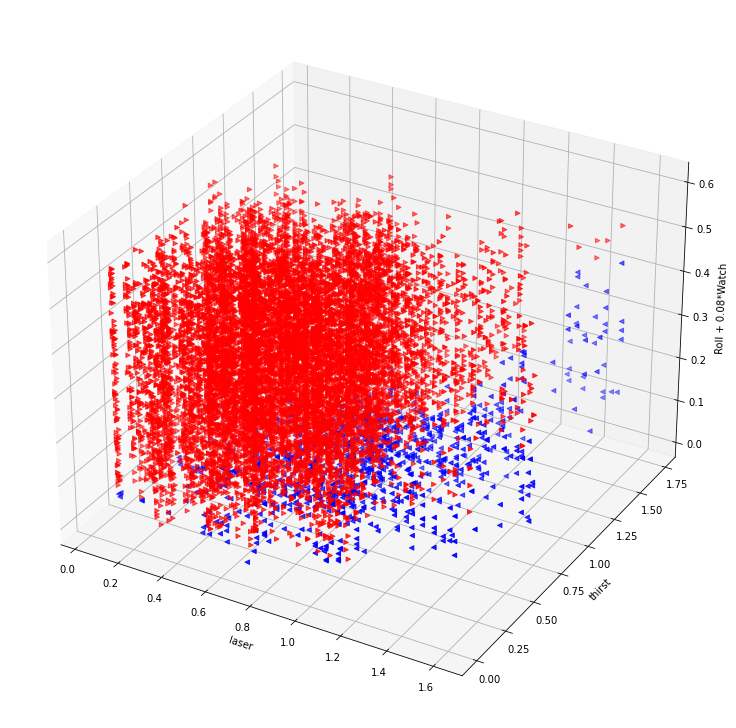

In [746]:
# library
# x_val = "laser"
# y_val = "thirst"
# z_val = "roll_mod"
# # We are going to do 20 plots, for 20 different angles
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# for angle in range(0,360,2):

#     # Make the plot
#     ax.scatter(
#         dfc[~dfc["passed"]][x_val],
#         dfc[~dfc["passed"]][y_val],
#         dfc[~dfc["passed"]]["roll_mod"],
#         color="red",
#         label="No Steal",
#         marker=">",
#     )
#     ax.scatter(
#         dfc[dfc["passed"]][x_val],
#         dfc[dfc["passed"]][y_val],
#         dfc[dfc["passed"]]["roll_mod"],
#         color="blue",
#         label="Steal",
#         marker="<",
#     )
#     ax.set_xlabel(x_val)
#     ax.set_ylabel(y_val)
#     ax.set_zlabel('Roll + 0.08*Watch')
#     ax.view_init(30,angle)

#     filename=f'spinny/spinny_step{angle:03d}.png'
#     plt.savefig(filename, dpi=96)
#     plt.cla()
    

fig = plt.figure(figsize=(10,10), layout="constrained")
ax = fig.add_subplot(projection='3d')
x_val = "laser"
y_val = "thirst"
z_val = "roll_mod"
ax.scatter(
    dfc[(~dfc["passed"]) & (dfc["roll"] < 0.5)][x_val],
    dfc[(~dfc["passed"]) & (dfc["roll"] < 0.5)][y_val],
    dfc[(~dfc["passed"]) & (dfc["roll"] < 0.5)]["roll_mod"],
    color="red",
    label="No Steal",
    marker=">",
)
ax.scatter(
    dfc[(dfc["passed"]) & (dfc["roll"] < 0.5)][x_val],
    dfc[(dfc["passed"]) & (dfc["roll"] < 0.5)][y_val],
    dfc[(dfc["passed"]) & (dfc["roll"] < 0.5)]["roll_mod"],
    color="blue",
    label="Steal",
    marker="<",
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_zlabel('Roll + 0.08*Watch')

In [152]:
# visualize threshold's dependence on factors
(0.002425175057980378, 'laser_vibe')
(0.009225215395203299, 'lasersq')
(0.018780306391243128, 'laser_thirst')
(0.07743226811827154, 'lasersq_thirst')
(0.0031124201530072877, 'laser_thirstsq')
(0.021536589516114663, 'batter_base_thirst')
(-0.0033105238341509424, 'thirstsq')
(-0.08052083106201309, 'watch')
(0.0, 'park_factors')
def fit_viz(laser, thirst, watch):
    y_int = 0.04290605609102509
    a = 0.002425175057980378
    b = 0.009225215395203299
    c = 0.018780306391243128
    d = 0.07743226811827154
    e = 0.0031124201530072877
    f = 0.021536589516114663
    g = -0.0033105238341509424
    h = -0.08052083106201309
    
    out = (
        y_int
        + a * laser
        + b * laser**2
        + c * laser * thirst
        + d * (laser**2) * thirst
        + e * laser*(thirst**2)
        + f * thirst
        + g * thirst**2
        + h * watch
    )
    return out

Text(0.5, 1.0, 'ln(threshold), watch = 0.5')

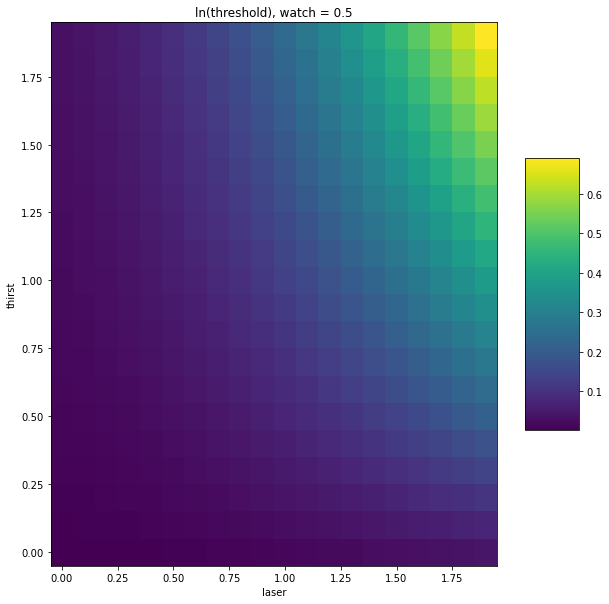

In [788]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
laser_x = np.arange(0, 2.0, 0.1)
thirst_y = np.arange(0, 2.0, 0.1)
# thirst_const = 0.001
watch_const = 0.5
threshold_y = fit_viz(laser_x, thirst_const, watch_const)


fig, ax = plt.subplots(figsize=(10,10))

# Make data.
X, Y = np.meshgrid(laser_x, thirst_y)
Z = (fit_viz(X, Y, watch_const))
# Plot the surface.
surf = ax.pcolormesh(X, Y, Z)
                       # linewidth=0, antialiased=False)

    
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# fig, ax = plt.subplots(1, figsize=(6, 6))
# ax.plot(laser_x, threshold_y)
# ax.plot([laser_x[0], laser_x[-1]], [threshold_y[0], threshold_y[-1]])
ax.set_xlabel("laser")
ax.set_ylabel("thirst")
ax.set_title(f"ln(threshold), watch = {watch_const}")
# ax.grid()
# ax.set_ylim(0, 0.08)

In [803]:
# for n in range(20):
#     plt.plot(Z[n,:])
# plt.figure()
# for n in range(20):
#     plt.plot(Z[:,n])

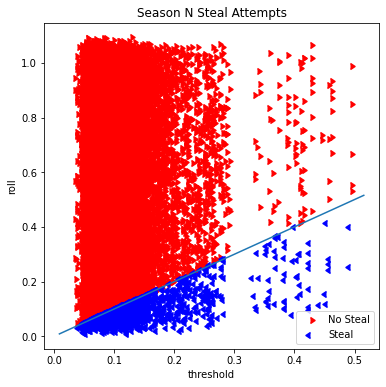

In [1327]:
# season 13, null stadium only
# [[26065     0]
#  [    0  1153]]
# 0 outliers
# 1.0
# intercept: 0.043272646512567126
# (0.002301879255231324, 'laser_vibe'),
# (0.0076657470915077715, 'lasersq'),
# (0.0269960061526303, 'laser_thirst'),
# (0.07758523709024914, 'lasersq_thirst'),
# (-0.0032036086834798284, 'laser_thirstsq'),
# (0.0171756417623993, 'batter_base_thirst'),
# (-0.06039525672661708, 'pwatch'),
# (-0.019936549618782263, 'fwatch'),

# dfc["threshold"] = intercept_scaled[0]
# print("intercept:", intercept_scaled)
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]
        
y_val = "roll_mod"
x_val = "threshold"
# x_val = "watch"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(-0.01, 0.01)
# ax.set_xlim(-0.1, 0.1)
# ax.set_yscale("log")
# ax.set_xscale("log")
# if x_val == "threshold":
ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

Text(0, 0.5, 'offset')

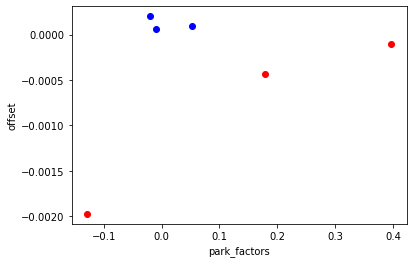

In [1333]:
dfc["offset"] = dfc["roll_mod"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
x_val = "thirst"
# x_val = "elong_center"
x_val = "park_factors"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Steal",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
# ax.legend()
# ax.set_ylim(0,2)

In [1334]:
# pd.set_option("display.max_rows", None)  # default 60
pd.set_option("display.max_columns", 20)  # default 20
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        # "pitcher_mul",
        # "batter_mul",
        # "fielder_mul",  # "baserunner_count",
        # "batter_vibes", "pitcher_vibes",
        "laser",
        "thirst",
        "laser_thirst_term",
        "watch",
        "incon_center",
        "elong_center",
        "park_factors",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        # "batter_mods",
        # "pitcher_mods",
        # "fielder_mods",
        # "batting_team_mods",
        # "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "stadium_id",
        # "fielder_roll",
    ]
]
print(len(table))
print(table.groupby("season").size())
table.sort_values("offset", ascending=False)#[0:10]

6
season
12    6
dtype: int64


,passed,offset,roll,threshold,laser,thirst,laser_thirst_term,watch,incon_center,elong_center,park_factors,batter_name,pitcher_name,fielder_name,season,day,game_id,play_count,stadium_id
143847,True,0.000203,0.066164,0.113309,0.608831,1.083708,0.466227,0.591854,-0.028788,0.003937,-0.020915,Jessica Telephone,Yummy Elliott,Valentine Games,12,73,3f414b8a-2a24-4861-a1fe-3ad15e8f7a9d,124,36b94380-39a6-4e32-b525-3e888215798a
145426,True,0.000093,0.043136,0.106902,0.674732,0.879935,0.448882,0.798242,-0.088660,0.070287,0.051915,Alston Cerveza,Bontgomery Mullock,Milo Brown,12,74,a828ea3d-7b51-47fe-9314-9177f01a5c19,334,1c1614b3-abdb-4008-98eb-12aeb8f7bb54
90248,True,0.000062,0.064451,0.090063,1.209055,0.193203,0.270218,0.320928,0.181991,-0.095923,-0.009855,Scratch Deleuze,Sixpack Santiago,Don Elliott,12,88,b508b99f-4611-4647-9d99-3d7456477d94,382,8a84154e-80d7-47d5-8f56-295e9a9653d9
261955,False,-0.000106,0.004018,0.064564,0.355978,0.904771,0.166509,0.755508,0.281742,0.057553,0.396848,Cannonball Sports,Flattery McKinley,Mint Shupe,12,83,4c87a7c4-05e7-43d9-973b-cf97361713d5,25,37c2743f-1a15-4e3f-bdb1-a6461df93434
98547,False,-0.000435,0.169594,0.175846,1.058692,0.985459,1.089222,0.072716,0.096246,0.040903,0.178051,Paula Turnip,Jenkins Good,Ziwa Mueller,12,97,70cfe929-4b25-405c-8ba9-ab777f25eb74,70,cb94ac8b-003b-4d95-baf3-7c14b1c3fc29
265118,False,-0.001977,0.040629,0.065893,0.088622,0.906807,0.025432,0.291092,-0.085568,-0.021770,-0.129108,Lotus Mango,Kathy Mathews,Steph Weeks,12,86,962cfad6-1a6b-4618-8727-2a0df5fabc85,74,7f09624b-b3cf-4493-b768-adf090bebf21


In [18]:
# dfc.corr()["offset"].sort_values()[-80:-30]

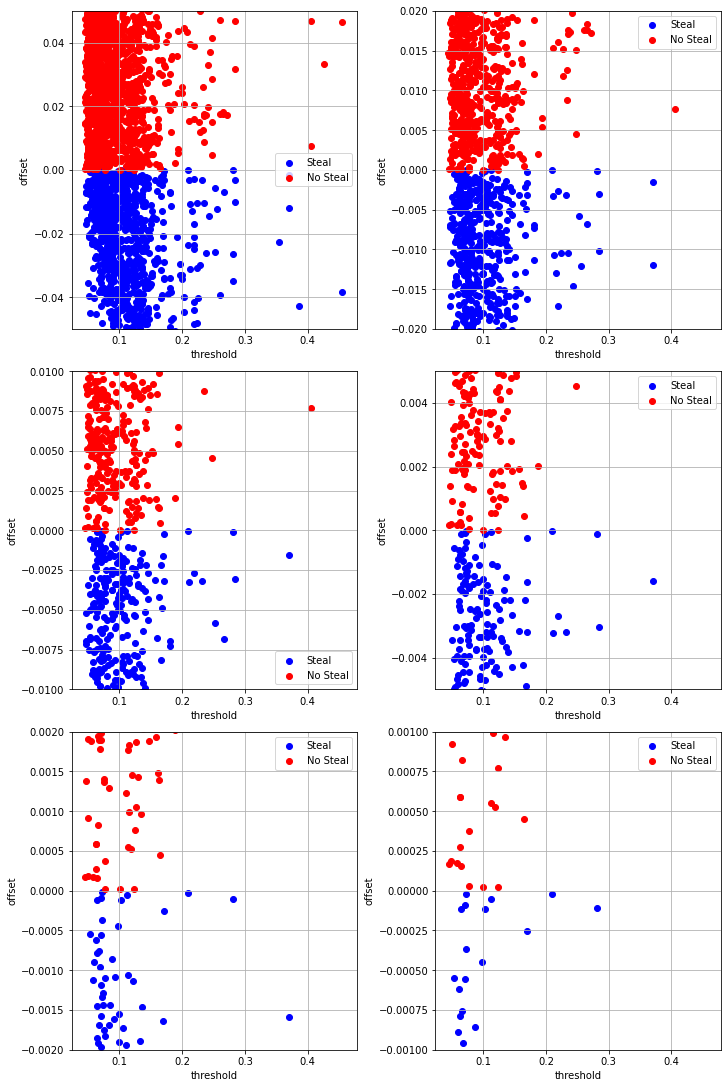

In [1277]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Steal",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')

## Best formulas so far

KeyError: 'laser_thirst_2'

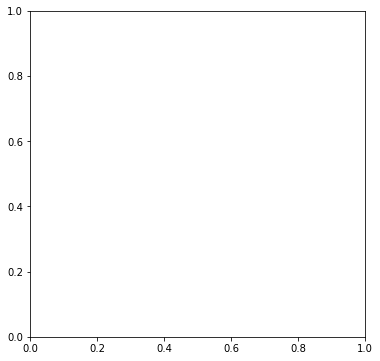

In [20]:
y_val = "roll"
x_val = "laser_thirst_2"
# x_val = "combined"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(-0.2, 0.2)

# if x_val == "threshold":
# ax.plot(ax.get_xlim(), 1.5*np.array(ax.get_xlim()))

ax.legend()

In [ ]:
# dfc["threshold"] = 0.075 - (
#     -0.131 * dfc["laser_thirst"]
#     + 0.06 * dfc["pitcher_watchfulness_mul_vibe"]
#     + 0.02 * dfc["fielder_watchfulness_mul_vibe"]
#     + 0.055 * dfc["ballpark_elongation"]
#     + 0.05 * dfc["ballpark_inconvenience"]
# )

# # this will usethe fit values
# dfc["threshold"] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] not in ["roll", "roll_log", "roll_corr"]:
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]


y_val = "roll"
x_val = "threshold"
# x_val = "laser_log"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(0, 0.5)

# if x_val == "threshold":
    # ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

##### Unrelated stuff

In [ ]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]
    press = df[prefix + "_pressurization"]
    cinn = df[prefix + "_cinnamon"]

    period = 6 + (buoy * 10).round()
    phase = np.pi * ((2 / period) * df["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

In [ ]:
foo = pd.DataFrame({"dunlap_buoyancy": 0.862,
                    "dunlap_pressurization": 0.935,
                    # "dunlap_cinnamon": 1.121,
                    "dunlap_cinnamon": 0.971,
                    "bertie_buoyancy": 0.198,
                    "bertie_pressurization": 0.689,
                    "bertie_cinnamon": 0.022,
                    "bertie_s8_buoyancy": 0.298,
                    "bertie_s8_pressurization": 0.689,
                    "bertie_s8_cinnamon": 0.022,
                    "day": np.arange(116)})

In [ ]:
foo["dunlap_vibes"] = calc_vibes(foo, "dunlap")
foo["bertie_vibes"] = calc_vibes(foo, "bertie")
foo["bertie_s8_vibes"] = calc_vibes(foo, "bertie_s8")

In [ ]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:116]+1, foo["dunlap_vibes"][:116], '.-')
plt.plot(foo["day"][3:99:5]+1, foo["dunlap_vibes"][3:99:5], 'yo')
plt.plot(foo["day"][103]+1, foo["dunlap_vibes"][103], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Dunlap's Vibes, season 4")
# plt.xlim(1,15)
# plt.ylim(-1,1)

In [ ]:
s8_day = np.array(foo["day"][:68]+1)
s8_day = np.append(s8_day, (foo["day"][67:]+1))
s8_vibes = np.array(foo["bertie_s8_vibes"][:68])
s8_vibes = np.append(s8_vibes, (foo["bertie_vibes"][67:]))
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(s8_day[:113], s8_vibes[:113], '.-')
plt.plot(s8_day[2:68:5], s8_vibes[2:68:5], 'yo')
plt.plot(s8_day[6:68:5], s8_vibes[6:68:5], 'yo')
plt.plot(s8_day[68:99:5], s8_vibes[68:99:5], 'yo')
plt.plot(s8_day[72:99:5], s8_vibes[72:99:5], 'yo')
plt.plot(s8_day[102], s8_vibes[102], 'yo')
plt.plot(s8_day[104], s8_vibes[104], 'yo')
plt.plot(s8_day[109], s8_vibes[109], 'yo')
plt.plot(s8_day[110], s8_vibes[110], 'yo')

plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 8")
# plt.xlim(1,15)
plt.ylim(-1,1)
# print(s8_day[2:68:5], s8_day[68:99:5])
# print(s8_day[6:68:5], s8_day[72:99:5])

In [ ]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:116]+1, foo["bertie_vibes"][:116], '.-')
plt.plot(foo["day"][3:99:5]+1, foo["bertie_vibes"][3:99:5], 'yo')
plt.plot(foo["day"][104]+1, foo["bertie_vibes"][104], 'yo')
plt.plot(foo["day"][110]+1, foo["bertie_vibes"][110], 'yo')
plt.plot(foo["day"][111]+1, foo["bertie_vibes"][111], 'yo')
plt.plot(foo["day"][115]+1, foo["bertie_vibes"][115], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 9")
# plt.xlim(1,15)
plt.ylim(-1,1)

In [ ]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:113]+1, foo["bertie_vibes"][:113], '.-')
plt.plot(foo["day"][2:99:4]+1, foo["bertie_vibes"][2:99:4], 'yo')
plt.plot(foo["day"][103]+1, foo["bertie_vibes"][103], 'yo')
plt.plot(foo["day"][109]+1, foo["bertie_vibes"][109], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 10")
# plt.xlim(1,15)
plt.ylim(-1,1)